Download Link: https://fred.stlouisfed.org/series/MRTSSM451211USN

In [1]:
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Sequential

from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import shift
from statsmodels.tsa.seasonal import seasonal_decompose

2021-11-25 11:37:09.477107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 11:37:09.477194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load data
path = "./data/book-sales.csv"
with open(path, "r") as fp:
    lines = fp.readlines()

sales = np.array([float(l.split(",")[1].strip()) for l in lines[1:]])
dates = np.array([datetime.strptime(l.split(",")[0], "%Y-%m-%d") for l in lines[1:]])

In [3]:
# Train test split
TEST_SPLIT = 0.8
split_idx = int(len(sales)*TEST_SPLIT)
train_sales = sales[:split_idx]
train_dates = dates[:split_idx]
test_sales = sales[split_idx:]
test_dates = dates[split_idx:]
assert(len(sales) == len(train_sales) + len(test_sales))

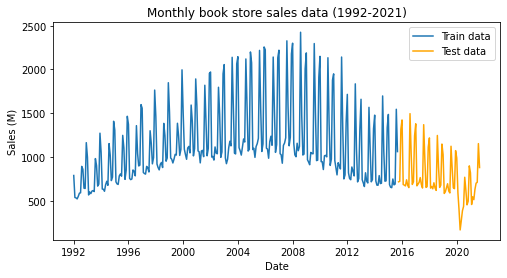

In [4]:
# Plot data
plt.figure(figsize=(8, 4))
plt.plot(train_dates, train_sales)
plt.plot(test_dates, test_sales, color="orange")
plt.title("Monthly book store sales data (1992-2021)")
plt.xlabel("Date")
plt.ylabel("Sales (M)")
plt.legend(["Train data", "Test data"])
plt.show()

In [5]:
# Standardize
train_mean = np.mean(train_sales)
train_stddev = np.std(train_sales)
train_sales_std = (train_sales - train_mean) / train_stddev
test_sales_std = (test_sales - train_mean) / train_stddev

In [6]:
# Create train/test examples
# X: (num samples, sample size, num features)
# y: (num samples, num outputs)
MIN_SAMPLE_SIZE = 12
num_train = len(train_sales)
train_X = np.zeros((num_train-MIN_SAMPLE_SIZE, num_train-1, 1))
train_y = np.zeros((num_train-MIN_SAMPLE_SIZE, 1))
for i in range(0, num_train-MIN_SAMPLE_SIZE):
    train_X[i, -(i+MIN_SAMPLE_SIZE):, 0] = train_sales_std[0:i+MIN_SAMPLE_SIZE]
    train_y[i, 0] = train_sales_std[i+MIN_SAMPLE_SIZE]
print("Train X shape:", train_X.shape)
print("Train y shape:", train_y.shape)

num_test = len(test_sales)
test_X = np.zeros((num_test-MIN_SAMPLE_SIZE, num_test-1, 1))
test_y = np.zeros((num_test-MIN_SAMPLE_SIZE, 1))
for i in range(0, num_test-MIN_SAMPLE_SIZE):
    test_X[i, -(i+MIN_SAMPLE_SIZE):, 0] = test_sales_std[0:i+MIN_SAMPLE_SIZE]
    test_y[i, 0] = test_sales_std[i+MIN_SAMPLE_SIZE]
print("Test X shape:", test_X.shape)
print("Test y shape:", test_y.shape)

Train X shape: (273, 284, 1)
Train y shape: (273, 1)
Test X shape: (60, 71, 1)
Test y shape: (60, 1)


In [7]:
train_X[272][:10]

array([[-0.80529038],
       [-1.38036572],
       [-1.38953027],
       [-1.41702391],
       [-1.35058094],
       [-1.26580888],
       [-1.25893547],
       [-0.56701215],
       [-0.64261966],
       [-1.13750522]])

In [8]:
# Create model 
model = Sequential()
model.add(
    SimpleRNN(input_shape=(None, 1), units=128, activation="relu"),
)
model.add(
    Dense(units=1, activation="linear")
)

2021-11-25 11:37:13.089074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-25 11:37:13.089096: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-25 11:37:13.089135: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calcifer-Inspiron-7370): /proc/driver/nvidia/version does not exist
2021-11-25 11:37:13.089416: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Compile
model.compile(
    optimizer="adam", 
    loss="mean_squared_error", 
    metrics=["mean_absolute_error"],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train
EPOCHS=64
BATCH_SIZE=32
model.fit(
    x=train_X, 
    y=train_y, 
    validation_data=(test_X, test_y), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/64
9/9 [==============================] - 1s 75ms/step - loss: 0.9305 - mean_absolute_error: 0.7133 - val_loss: 0.7297 - val_mean_absolute_error: 0.7756
Epoch 2/64
9/9 [==============================] - 1s 60ms/step - loss: 0.6597 - mean_absolute_error: 0.5809 - val_loss: 0.4369 - val_mean_absolute_error: 0.5835
Epoch 3/64
9/9 [==============================] - 1s 63ms/step - loss: 0.4453 - mean_absolute_error: 0.4942 - val_loss: 0.2194 - val_mean_absolute_error: 0.3856
Epoch 4/64
9/9 [==============================] - 1s 63ms/step - loss: 0.2237 - mean_absolute_error: 0.3565 - val_loss: 0.1239 - val_mean_absolute_error: 0.2317
Epoch 5/64
9/9 [==============================] - 1s 60ms/step - loss: 0.1378 - mean_absolute_error: 0.2928 - val_loss: 0.0867 - val_mean_absolute_error: 0.1892
Epoch 6/64
9/9 [==============================] - 1s 60ms/step - loss: 0.0774 - mean_absolute_error: 0.2126 - val_loss: 0.0718 - val_mean_absolute_error: 0.1752
Epoch 7/64
9/9 [==================

In [11]:
# Predict test
test_predictions_std = model.predict(test_X)
test_predictions = test_predictions_std*train_stddev + train_mean
test_predictions.shape

(60, 1)

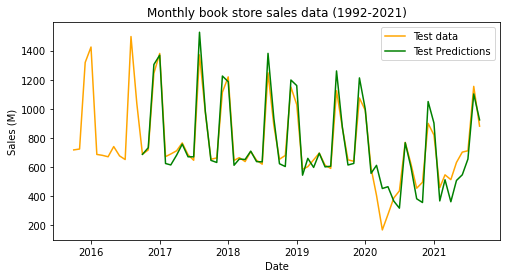

In [12]:
# Plot data
plt.figure(figsize=(8, 4))
plt.plot(test_dates, test_sales, color="orange")
plt.plot(test_dates[MIN_SAMPLE_SIZE:], test_predictions, color="green")
plt.title("Monthly book store sales data (1992-2021)")
plt.xlabel("Date")
plt.ylabel("Sales (M)")
plt.legend(["Test data", "Test Predictions"])
plt.show()

# Adding other features

In [133]:
NUM_FEATURES = 2

In [134]:
seasonal_decomposition_train = seasonal_decompose(train_sales, period=12)
seasonal_decomposition_test = seasonal_decompose(train_sales, period=12)

In [135]:
# Add features
train_sales_aug = np.stack((
    train_sales,
    np.power(train_sales, 2),
    # seasonal_decomposition_train.trend,
    # seasonal_decomposition_train.seasonal,
    # seasonal_decomposition_train.resid,
), axis=1)
print("Train sales Augmented shape:", train_sales_aug.shape)

test_sales_aug = np.stack((
    test_sales, 
    np.power(test_sales, 2), 
    # seasonal_decomposition_test.trend,
    # seasonal_decomposition_test.seasonal,
    # seasonal_decomposition_test.resid,
), axis=1)
print("Test sales Augmented shape:", test_sales_aug.shape)

Train sales Augmented shape: (285, 2)
Test sales Augmented shape: (72, 2)


In [136]:
train_sales_aug_cld = np.nan_to_num(train_sales_aug, 0)
test_sales_aug_cld = np.nan_to_num(test_sales_aug, 0)

In [137]:
# Standardize
train_aug_mean = np.mean(train_sales_aug_cld, axis=0)
train_aug_stddev = np.std(train_sales_aug_cld, axis=0)
train_sales_aug_std = (train_sales_aug_cld - train_aug_mean) / train_aug_stddev
test_sales_aug_std = (test_sales_aug_cld - train_aug_mean) / train_aug_stddev

In [138]:
# Create train/test examples
# X: (num samples, sample size, num features)
# y: (num samples, num outputs)
MIN_SAMPLE_SIZE = 12
num_train = len(train_sales_aug_std)
train_X_aug = np.zeros((num_train-MIN_SAMPLE_SIZE, num_train-1, NUM_FEATURES))
train_y = np.zeros((num_train-MIN_SAMPLE_SIZE, 1))
for i in range(0, num_train-MIN_SAMPLE_SIZE):
    train_X_aug[i, -(i+MIN_SAMPLE_SIZE):, :] = train_sales_aug_std[0:i+MIN_SAMPLE_SIZE]
    train_y[i, 0] = train_sales_std[i+MIN_SAMPLE_SIZE]
print("Train X shape:", train_X_aug.shape)
print("Train y shape:", train_y.shape)

num_test = len(test_sales)
test_X_aug = np.zeros((num_test-MIN_SAMPLE_SIZE, num_test-1, NUM_FEATURES))
test_y = np.zeros((num_test-MIN_SAMPLE_SIZE, 1))
for i in range(0, num_test-MIN_SAMPLE_SIZE):
    test_X_aug[i, -(i+MIN_SAMPLE_SIZE):, :] = test_sales_aug_std[0:i+MIN_SAMPLE_SIZE]
    test_y[i, 0] = test_sales_std[i+MIN_SAMPLE_SIZE]
print("Test X shape:", test_X_aug.shape)
print("Test y shape:", test_y.shape)

Train X shape: (273, 284, 2)
Train y shape: (273, 1)
Test X shape: (60, 71, 2)
Test y shape: (60, 1)


In [139]:
# Create model 
model = Sequential()
model.add(
    SimpleRNN(
        input_shape=(None, NUM_FEATURES), 
        units=128, 
        activation="relu",
        # return_sequences=True,
    )
)
# model.add(Dropout(0.2))
model.add(
    Dense(units=1, activation="linear")
)

In [140]:
# Compile
model.compile(
    optimizer="adam", 
    loss="mean_squared_error", 
    metrics=["mean_absolute_error"],
)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 128)               16768     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [149]:
# Train
EPOCHS=64
BATCH_SIZE=32
model.fit(
    x=train_X_aug, 
    y=train_y, 
    validation_data=(test_X_aug, test_y), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/64
9/9 [==============================] - 1s 108ms/step - loss: 0.0123 - mean_absolute_error: 0.0792 - val_loss: 0.0580 - val_mean_absolute_error: 0.1718
Epoch 2/64
9/9 [==============================] - 1s 102ms/step - loss: 0.0103 - mean_absolute_error: 0.0732 - val_loss: 0.0571 - val_mean_absolute_error: 0.1740
Epoch 3/64
9/9 [==============================] - 1s 106ms/step - loss: 0.0098 - mean_absolute_error: 0.0750 - val_loss: 0.0486 - val_mean_absolute_error: 0.1478
Epoch 4/64
9/9 [==============================] - 1s 113ms/step - loss: 0.0133 - mean_absolute_error: 0.0839 - val_loss: 0.0593 - val_mean_absolute_error: 0.1671
Epoch 5/64
9/9 [==============================] - 1s 106ms/step - loss: 0.0138 - mean_absolute_error: 0.0843 - val_loss: 0.0416 - val_mean_absolute_error: 0.1380
Epoch 6/64
9/9 [==============================] - 1s 106ms/step - loss: 0.0108 - mean_absolute_error: 0.0776 - val_loss: 0.0468 - val_mean_absolute_error: 0.1515
Epoch 7/64
9/9 [============

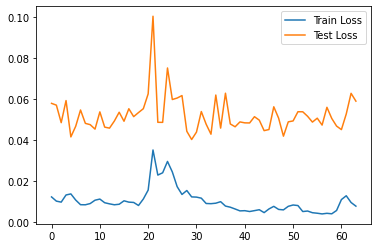

In [156]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(["Train Loss", "Test Loss"])

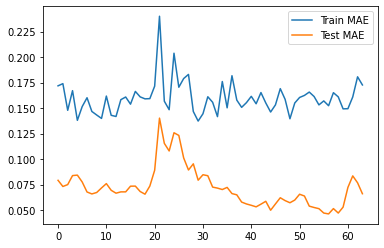

In [157]:
plt.plot(model.history.history['val_mean_absolute_error'])
plt.plot(model.history.history['mean_absolute_error'])
plt.legend(["Train MAE", "Test MAE"])

In [142]:
# Predict test
test_predictions_std = model.predict(test_X_aug)
test_predictions = test_predictions_std*train_stddev + train_mean
test_predictions.shape

(60, 1)

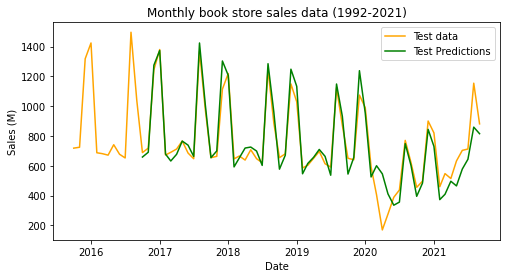

In [143]:
# Plot data
plt.figure(figsize=(8, 4))
plt.plot(test_dates, test_sales, color="orange")
plt.plot(test_dates[MIN_SAMPLE_SIZE:], test_predictions, color="green")
plt.title("Monthly book store sales data (1992-2021)")
plt.xlabel("Date")
plt.ylabel("Sales (M)")
plt.legend(["Test data", "Test Predictions"])
plt.show()